In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial

In [2]:
%matplotlib inline
from matplotlib import rc
rc('text', usetex=True)
font_size = 18
rc('font', size=font_size)
rc('axes', titlesize=font_size)
%config InlineBackend.figure_format = 'retina'

In [3]:
sys.path.append('../common')
import collect_dem

In [283]:
import scipy.sparse.csgraph as graph
def get_connected_components(tris):
    n_tris = tris.shape[0]
    touching = [[] for i in range(np.max(tris) + 1)]
    for i in range(n_tris):
        for d in range(3):
            touching[tris[i,d]].append(i)
    connectivity = np.zeros((n_tris, n_tris))
    for i in range(len(touching)):
        for row in touching[i]:
            for col in touching[i]:
                connectivity[row, col] = 1
    return graph.connected_components(connectivity)

def find_free_edges(tris):
    edges = dict()
    for i, t in enumerate(tris):
        for d in range(3):
            pt1_idx = t[d]
            pt2_idx = t[(d + 1) % 3]
            if pt1_idx > pt2_idx:
                pt2_idx,pt1_idx = pt1_idx,pt2_idx
            pt_pair = (pt1_idx, pt2_idx)
            edges[pt_pair] = edges.get(pt_pair, []) + [(i, d)]

    free_edges = []
    for k,e in edges.items():
        if len(e) > 1:
            continue
        free_edges.append(e[0])

    return free_edges

def get_boundary_loop(m):
    which_comp = get_connected_components(m[1])[1]
    n_surfaces = np.unique(which_comp).shape[0]
    orderings = []
    for surf_idx in range(2):
        tri_subset = m[1][which_comp == surf_idx]
        free_edges = find_free_edges(tri_subset)
        pt_to_pt = [
            (tri_subset[tri_idx, edge_idx], tri_subset[tri_idx, (edge_idx + 1) % 3])
            for tri_idx, edge_idx in free_edges
        ]

        pts_to_edges = dict()
        for i, e in enumerate(pt_to_pt):
            for lr in [0,1]:
                pts_to_edges[e[lr]] = pts_to_edges.get(e[lr], []) + [i]

        for k,v in pts_to_edges.items():
            assert(len(v) == 2)

        ordering = [pt_to_pt[0][0], pt_to_pt[0][1]]
        looped = False
        while not looped:
            pt_idx = ordering[-1]
            prev_pt_idx = ordering[-2]
            for e_idx in pts_to_edges[pt_idx]:
                edge = pt_to_pt[e_idx]
                if edge[0] == prev_pt_idx or edge[1] == prev_pt_idx:
                    continue
                if edge[0] == pt_idx:
                    ordering.append(edge[1])
                else:
                    ordering.append(edge[0])
            if ordering[-1] == ordering[0]:
                looped = True
        orderings.append(ordering)
    return orderings

def remove_unused_pts(m):
    referenced_pts = np.unique(m[1])
    new_pts = m[0][referenced_pts,:]
    new_indices = np.empty(m[0].shape[0], dtype = np.int64)
    new_indices[referenced_pts] = np.arange(referenced_pts.shape[0])
    new_tris = new_indices[m[1]]
    return (new_pts, new_tris)

def get_dem_bounds(lonlat_pts):
    minlat = np.min(lonlat_pts[:,1])
    minlon = np.min(lonlat_pts[:,0])
    maxlat = np.max(lonlat_pts[:,1])
    maxlon = np.max(lonlat_pts[:,0])
    latrange = maxlat - minlat
    lonrange = maxlon - minlon
    bounds = (
        minlat - latrange * 0.1,
        minlon - lonrange * 0.1,
        maxlat + latrange * 0.1,
        maxlon + lonrange * 0.1
    )
    return bounds

def get_pt_elevations(lonlat_pts, zoom, n_interp = 100):
    bounds = get_dem_bounds(lonlat_pts)
    LON, LAT, DEM = collect_dem.get_dem(zoom, bounds, n_dem_interp_pts)
    return scipy.interpolate.griddata(
        (LON, LAT), DEM, (lonlat_pts[:,0], lonlat_pts[:,1])
    )

In [132]:
#bounds = 29.361572, 98.207583, 33.579870, 106.743077
zoom = 5
proj = 'utm48R'
n_dem_interp_pts = 300
#proj = 'ellps'

In [6]:
from tectosaur.mesh.modify import remove_duplicate_pts
lon,lat,z,tris = np.load('wenchuan_fault_surf.npy', encoding = 'latin1')
pts = np.vstack((lon,lat,z)).T
pts, tris = remove_duplicate_pts((pts, tris))
which_comp = get_connected_components(tris)[1]

In [7]:
#remove the detachment
average_depth = np.zeros(3)
average_depth = np.mean(pts[tris,2], axis = 1)
component_depth = np.array([np.mean(average_depth[which_comp == d]) for d in range(3)])
detachment_component = np.where(component_depth < -21000)[0][0]
nondetachment_tris = tris[np.where(which_comp != detachment_component)[0]]

In [156]:
#remove unused pts
new_pts, new_tris = remove_unused_pts((pts, nondetachment_tris))

In [150]:
fault_pts = collect_dem.project(new_pts[:,0], new_pts[:,1], new_pts[:,2], proj)
fault_m = (fault_pts, new_tris)

48R


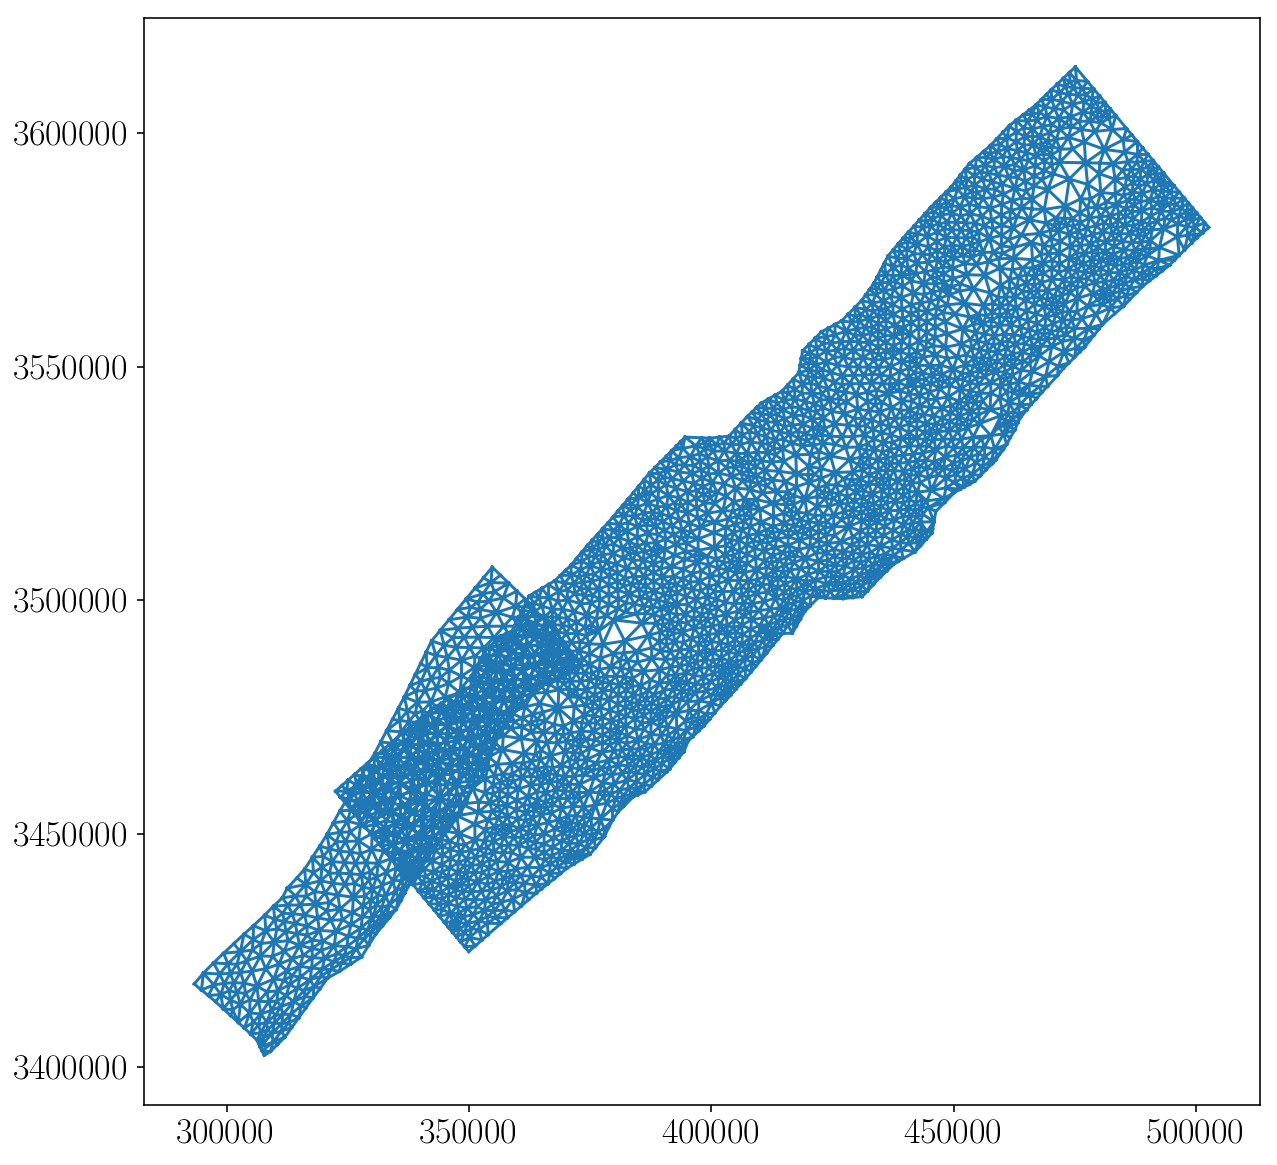

In [151]:
plt.figure(figsize = (10,10))
plt.triplot(fault_m[0][:,0], fault_m[0][:,1], fault_m[1])
plt.show()

In [11]:
import meshio
meshio.write('/tmp/dense_fault.msh', fault_m[0], {'triangle': fault_m[1]})

In [12]:
code = """
Merge "dense_fault.msh";
RefineMesh;
CreateTopology;

ll[] = Line "*";
For j In {0 : #ll[]-1}
  Compound Line(newl) = ll[j];
EndFor
ss[] = Surface "*";
s = news;
For i In {0 : #ss[]-1}
  Compound Surface(s+i) = ss[i];
EndFor

Field[1] = MathEval;
Field[1].F = "10000.0";
Background Field = 1;

Mesh.RemeshAlgorithm = 1;
Mesh.RemeshParametrization = 7;
Geometry.HideCompounds = 1;
"""
import pygmsh
geom = pygmsh.built_in.Geometry()
geom.add_raw_code(code)
simplify_pts, simplify_cells, point_data, cell_data, field_data = pygmsh.generate_mesh(geom, dim = 2, num_lloyd_steps = 0, num_quad_lloyd_steps = 0)

Info    : Running 'gmsh -2 -bin /tmp/tmpwru2wsl9.geo -o /tmp/tmplpjzszij.msh' [Gmsh 3.0.5, 1 node, max. 1 thread]
Info    : Started on Fri Oct 20 16:51:07 2017
Info    : Reading '/tmp/tmpwru2wsl9.geo'...
Info    : Reading '/tmp/dense_fault.msh'...
Info    : 3575 vertices
Info    : 6732 elements
Info    : Done reading '/tmp/dense_fault.msh'
Info    : Refining mesh...
Info    : Meshing order 2 (curvilinear on)...
Info    : Meshing surface 0 order 2
Info    : Finalized high order topology of periodic connections
Info    : Surface mesh: worst distortion = 1 (0 elements in ]0, 0.2]); worst gamma = 0.104272
Info    : Done meshing order 2 (0.018785 s)
Info    : Done refining mesh (0.031026 s)
Info    : Creating topology from mesh...
Info    : Removing duplicate mesh vertices...
Info    : Found 0 duplicate vertices 
Info    : No duplicate vertices found
Info    : Creating the geometry of discrete curves
Info    : Done creating topology from mesh (0.19339 s)
Info    : Done reading '/tmp/tmpwru2

In [157]:
simplify_tris = simplify_cells['triangle'][cell_data['triangle']['geometrical'] > 2]
fault_m = remove_unused_pts((simplify_pts, simplify_tris))
fault_m[0].shape[0], fault_m[1].shape[0]

(237, 386)

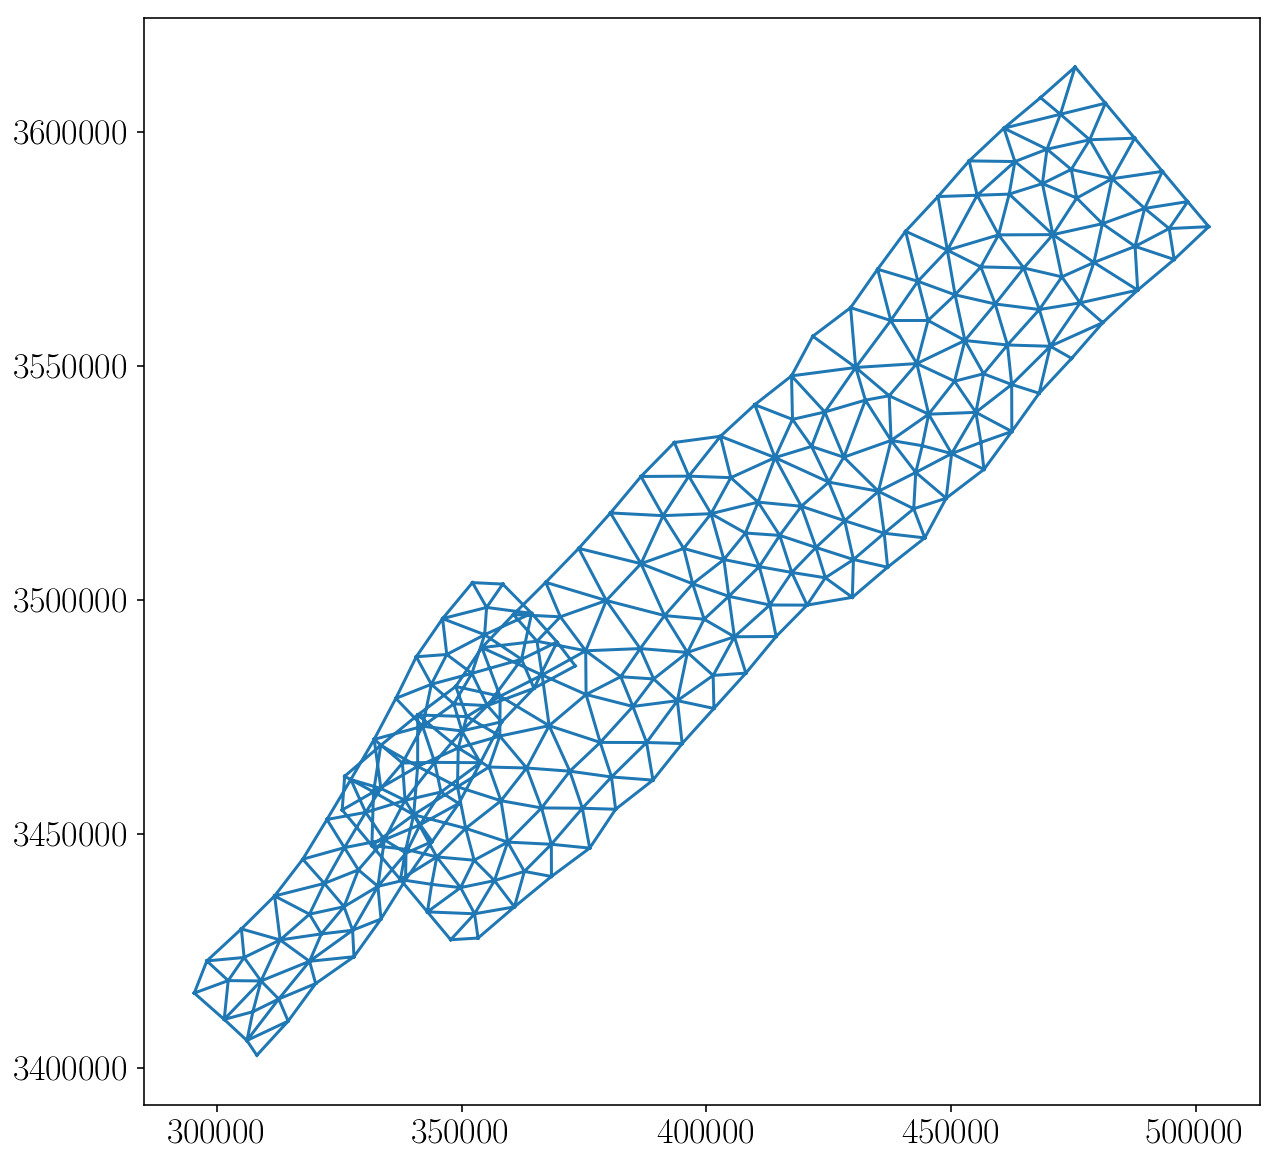

In [158]:
plt.figure(figsize = (10,10))
plt.triplot(fault_m[0][:,0], fault_m[0][:,1], fault_m[1])
plt.show()

In [170]:
orderings = get_boundary_loop(fault_m)

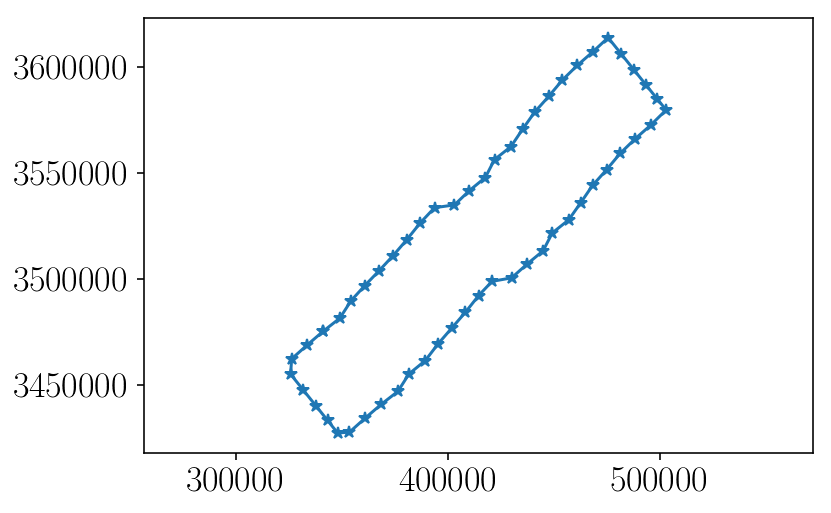

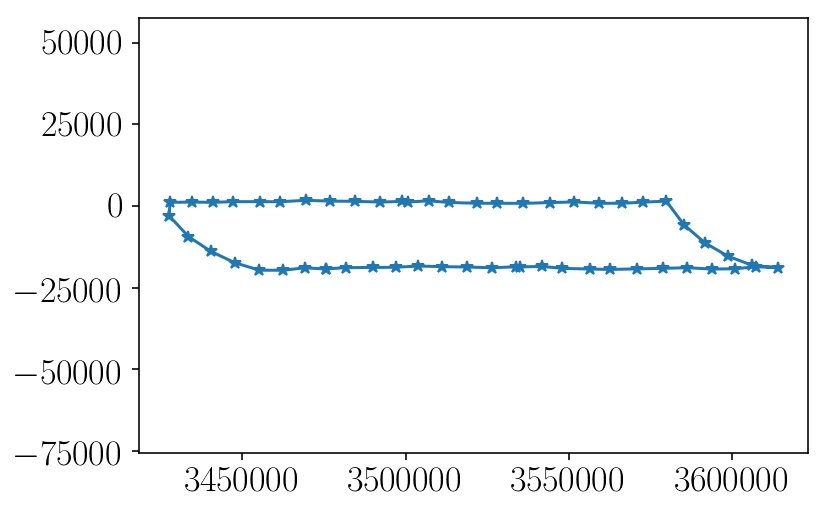

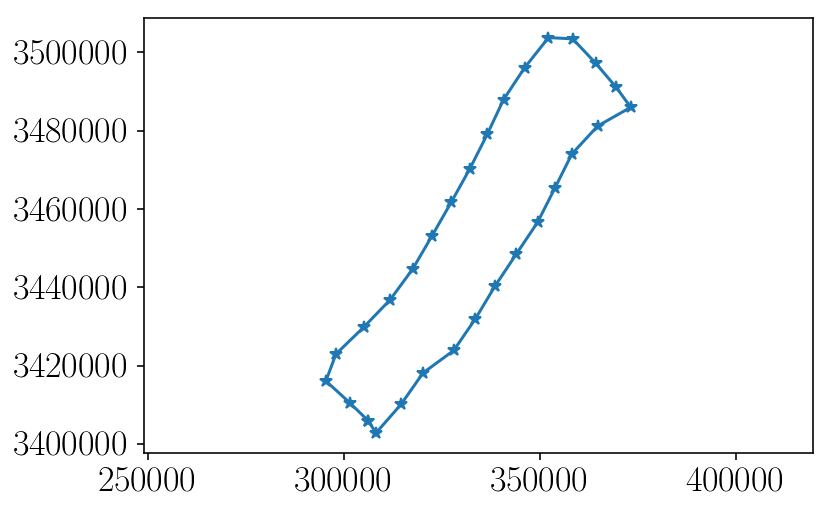

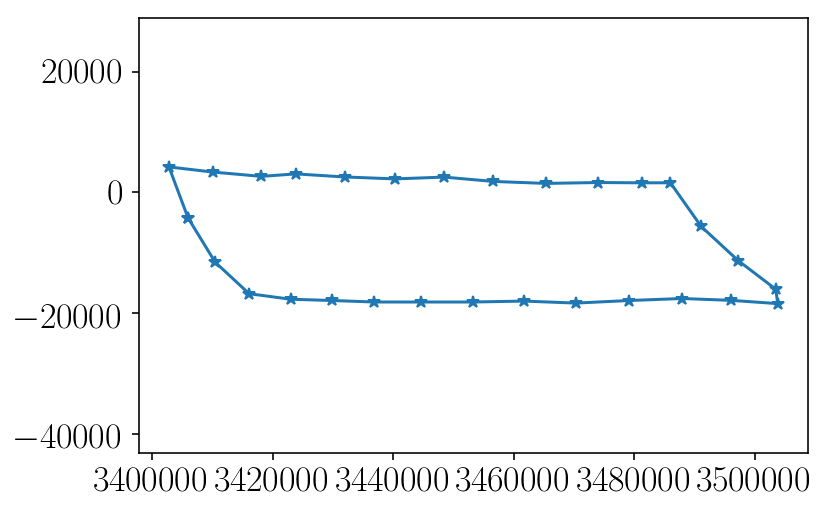

In [171]:
for i in range(len(orderings)):
    ordering = orderings[i]
    plt.figure()
    plt.plot(fault_m[0][ordering, 0], fault_m[0][ordering, 1], '-*')
    plt.axis('equal')
    plt.figure()
    plt.plot(fault_m[0][ordering, 1], fault_m[0][ordering, 2], '-*')
    plt.axis('equal')
    plt.show()

In [133]:
LON, LAT, DEM = collect_dem.get_dem(zoom, bounds, n_dem_interp_pts)

5 24 12
5 25 12
5 24 13
5 25 13


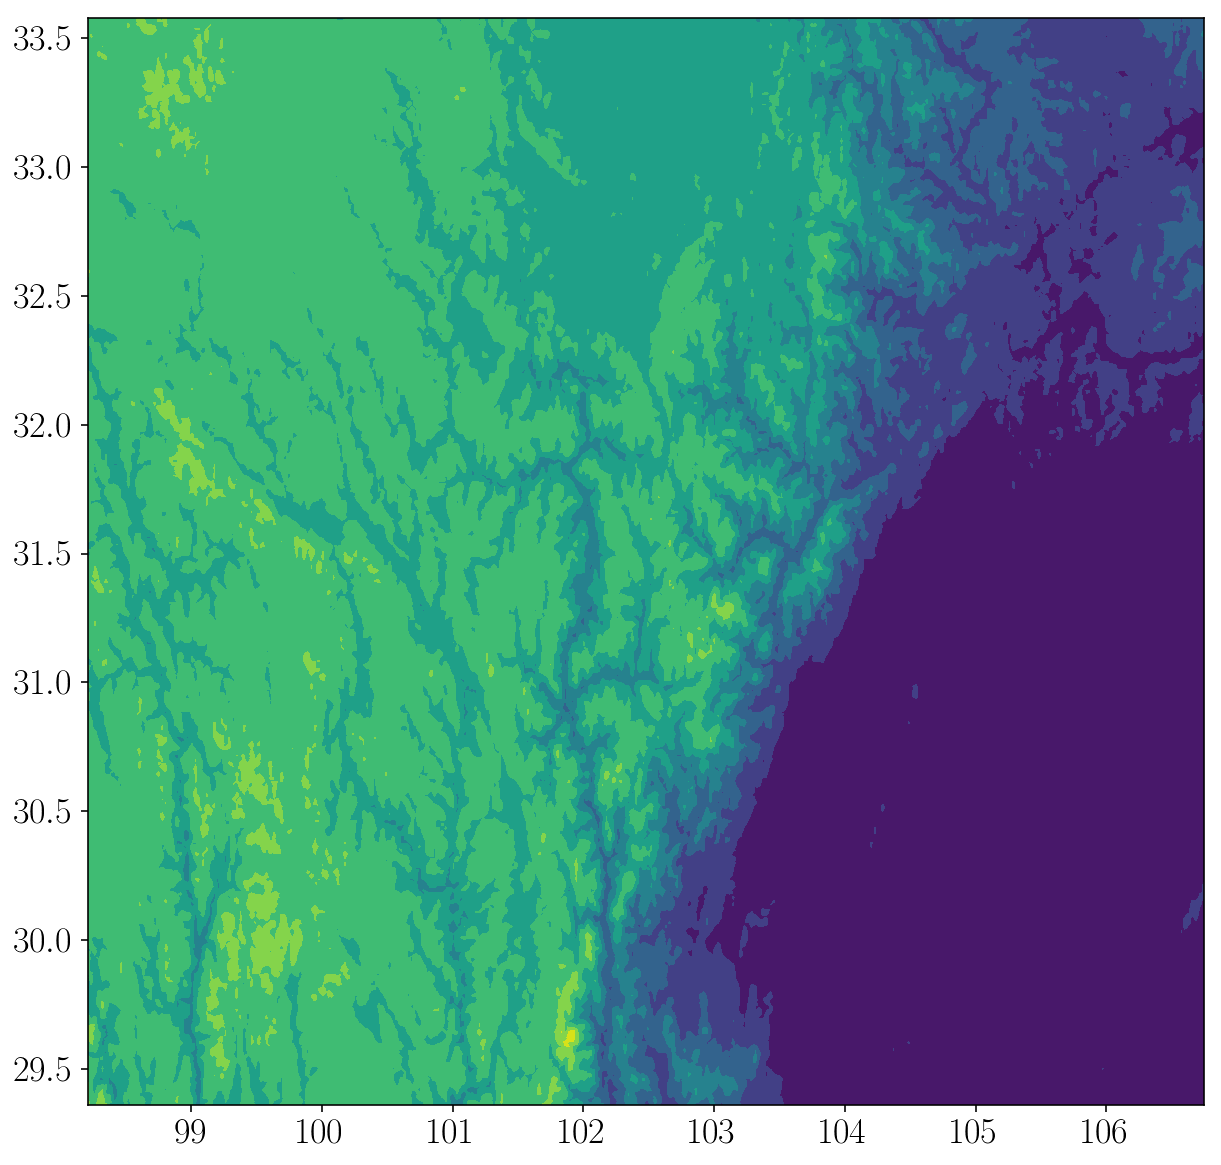

In [134]:
plt.figure(figsize = (10,10))
plt.tricontourf(LON, LAT, DEM)
plt.show()

In [114]:
proj_dem = collect_dem.project(LON, LAT, DEM, proj)

48R


In [284]:
import importlib; importlib.reload(collect_dem)
fault_pt_elevations = get_pt_elevations(
    collect_dem.project(fault_m[0][:,0], fault_m[0][:,1], fault_m[0][:,2], proj, inverse = True),
    zoom
)
# pt_elevations = scipy.interpolate.griddata(
#     (proj_dem[:,0], proj_dem[:,1]), proj_dem[:,2],
#     (fault_m[:,0], faullt[:,1])
# )

48R
5 25 12
5 25 13


In [289]:
vertical_diff = fault_pt_elevations - fault_m[0][:,2]
below_surf = np.abs(vertical_diff) >= 800
above_surf = np.logical_not(below_surf)

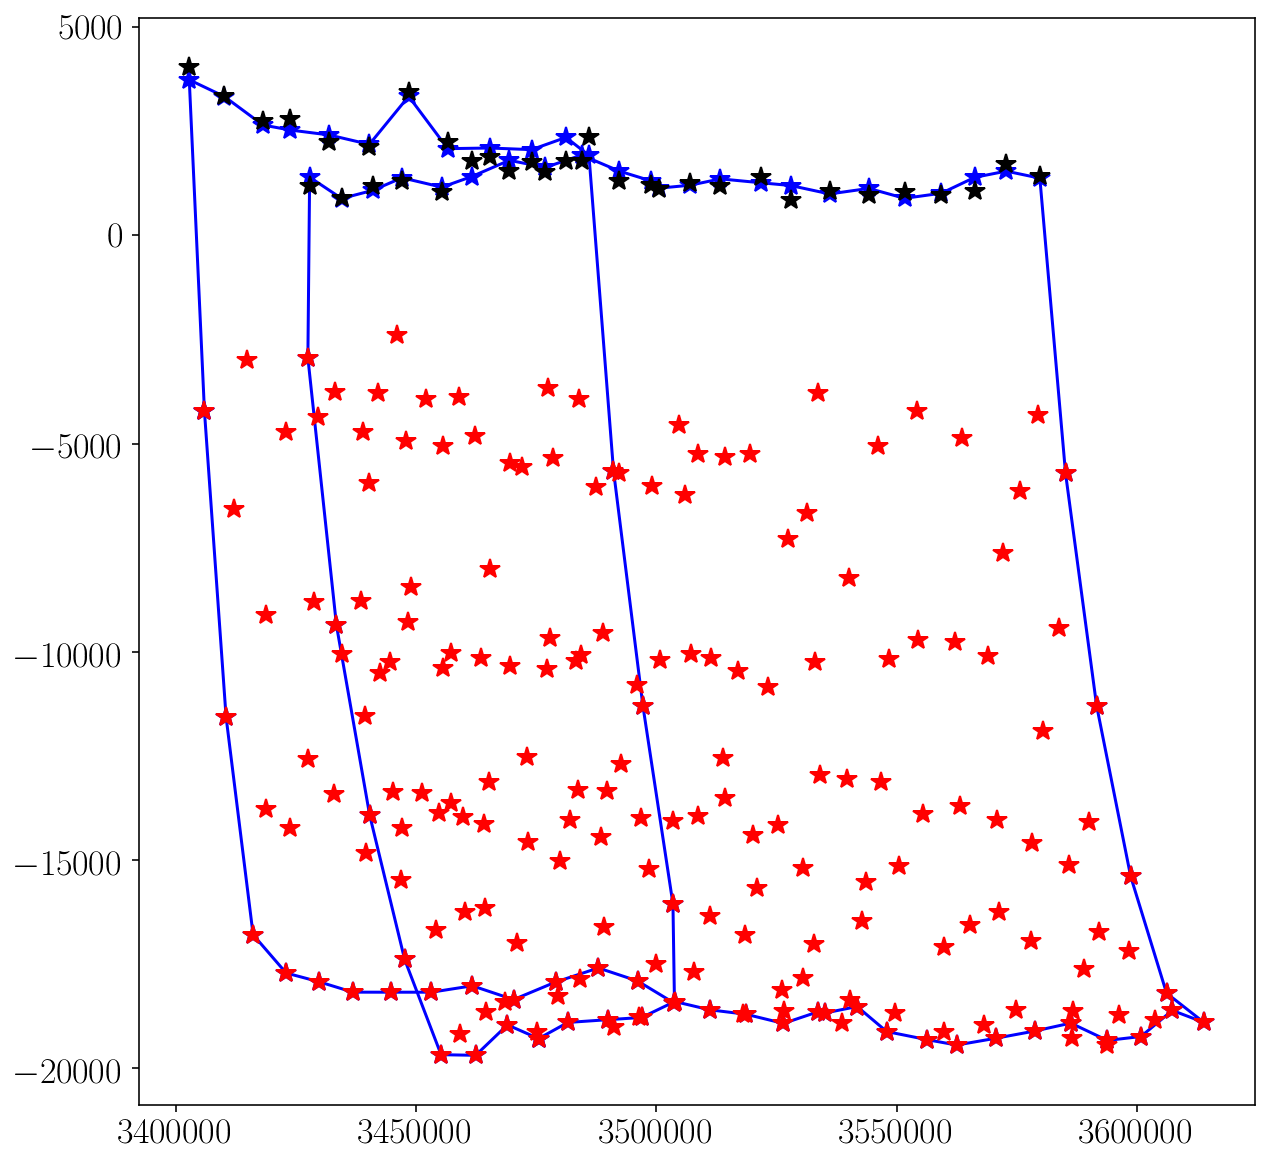

In [293]:
plt.figure(figsize = (10, 10))
for i in range(len(orderings)):
    plt.plot(fault_m[0][orderings[i], 1], fault_m[0][orderings[i], 2], 'b-*', markersize = 10)
plt.plot(fault_m[0][above_surf, 1], fault_pt_elevations[above_surf], 'k*', markersize = 10)
plt.plot(fault_m[0][below_surf, 1], fault_m[0][below_surf, 2], 'r*', markersize = 10, zorder = 10)
plt.show()

In [187]:
surface_fault_edges = []
for fault_edge in orderings:
    for i in range(len(fault_edge) - 1):
        vertex1 = fault_edge[i]
        vertex2 = fault_edge[i + 1]
        if below_surf[vertex1] or below_surf[vertex2]:
            continue
        surface_fault_edges.append((vertex1, vertex2))
surface_fault_edges = np.array(surface_fault_edges)

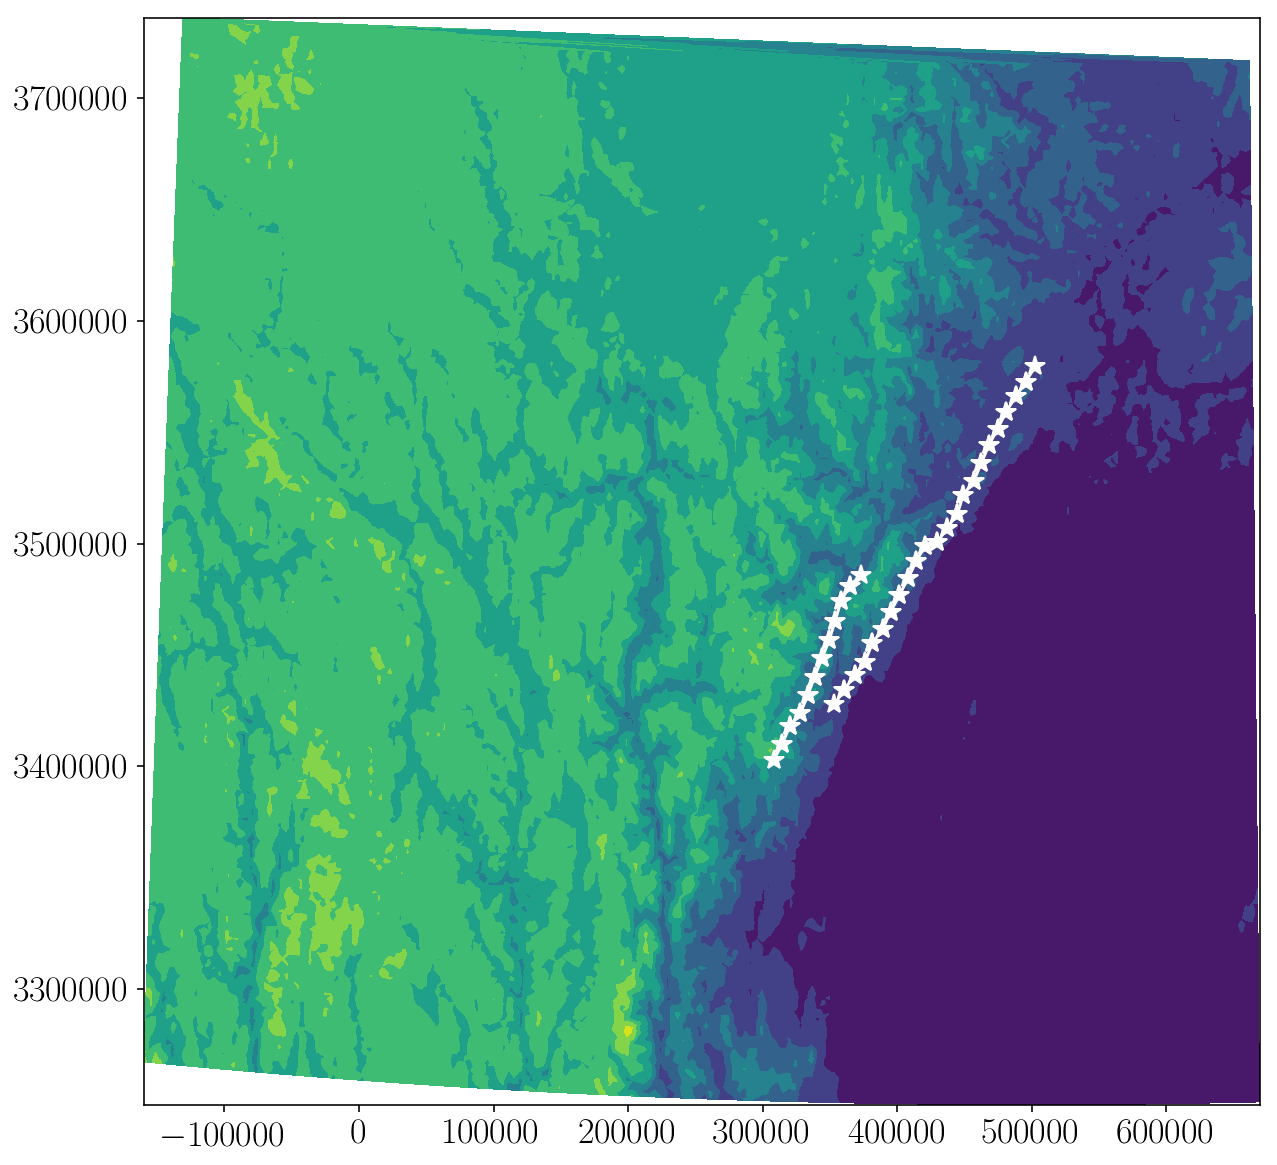

In [188]:
plt.figure(figsize = (10,10))
plt.tricontourf(proj_dem[:,0], proj_dem[:,1], proj_dem[:,2])
for edge in surface_fault_edges:
    pts = fault_m[0][edge]
    plt.plot(pts[:,0], pts[:,1], 'w-*', markersize = 10)
plt.show()

In [271]:
upper_edge_idxs = np.unique(surface_fault_edges)
upper_edge_pts = fault_m[0][upper_edge_idxs,:]
upper_edge_pts.shape

(35, 3)

In [267]:
surf_center = np.mean(upper_edge_pts, axis = 0)
fault_L = np.max(np.sqrt(np.sum((upper_edge_pts - surf_center) ** 2, axis = 1)))
mesh_size = fault_L / 5
surf_center, fault_L

(array([  3.98409151e+05,   3.48312593e+06,   1.60278421e+03]),
 142192.37157032787)

In [268]:
geom = pygmsh.built_in.Geometry()

w = fault_L * 4
surf_corners = np.array([
    [surf_center[0] - w, surf_center[1] - w, 0],
    [surf_center[0] + w, surf_center[1] - w, 0],
    [surf_center[0] + w, surf_center[1] + w, 0],
    [surf_center[0] - w, surf_center[1] + w, 0],
])
surf = geom.add_polygon(surf_corners, mesh_size)

gmsh_pts = dict()
for edge in surface_fault_edges:
    for j in range(2):
        if edge[j] not in gmsh_pts:
            gmsh_pts[edge[j]] = geom.add_point(fault_m[0][edge[j]], mesh_size)
    line = geom.add_line(gmsh_pts[edge[0]], gmsh_pts[edge[1]])
    intersection_code = 'Line{{{}}} In Surface{{{}}};'.format(
        line.id, surf.surface.id
    )
    geom.add_raw_code(intersection_code)

In [269]:
points, cells, pt_data, cell_data, field_data = pygmsh.generate_mesh(
    geom, dim = 2, num_lloyd_steps = 0, num_quad_lloyd_steps = 0
)

Info    : Running 'gmsh -2 -bin /tmp/tmpgxf54cjn.geo -o /tmp/tmpet2_dcai.msh' [Gmsh 3.0.5, 1 node, max. 1 thread]
Info    : Started on Fri Oct 20 20:50:43 2017
Info    : Reading '/tmp/tmpgxf54cjn.geo'...
Info    : Done reading '/tmp/tmpgxf54cjn.geo'
Info    : Finalized high order topology of periodic connections
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 2 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 8 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 11 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 14 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Meshing curve 17 (Line)
Info    : Meshing curve 18 (Line)
Info    : Meshing curve 19 (Line)
Info    : Meshing curve 20 (Line)
Info    : Meshing curve 21 (Line)
Info    : Meshing curve

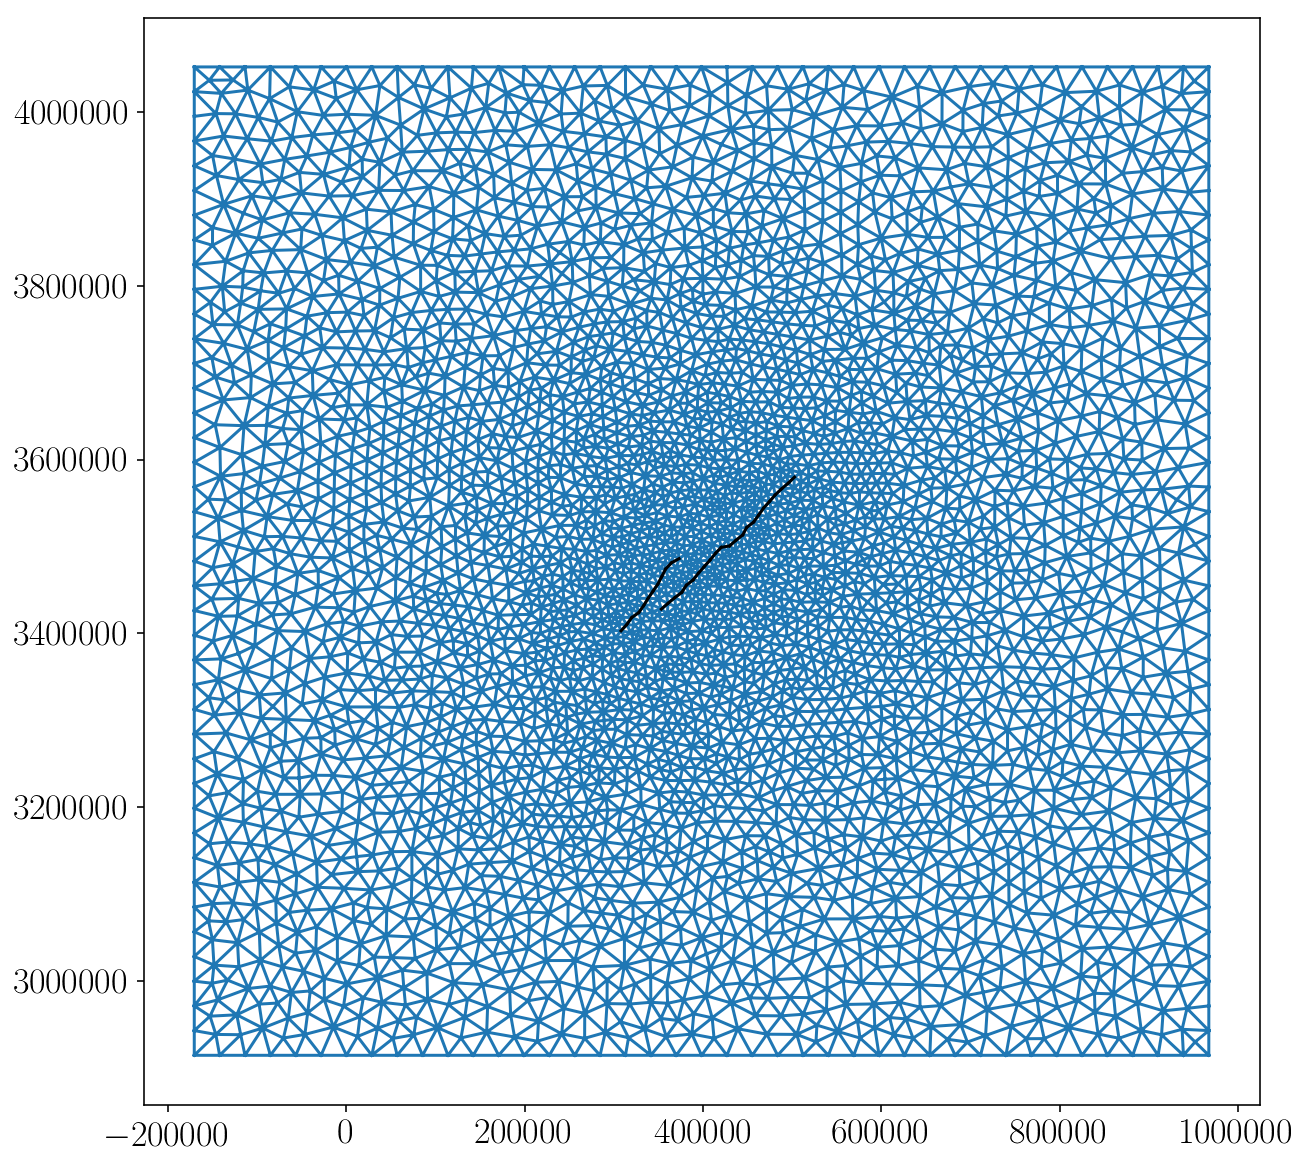

In [270]:
plt.figure(figsize = (10,10))
plt.triplot(points[:,0], points[:,1], cells['triangle'])
for edge in surface_fault_edges:
    pts = fault_m[0][edge]
    plt.plot(pts[:,0], pts[:,1], 'k-', markersize = 10)
plt.show()

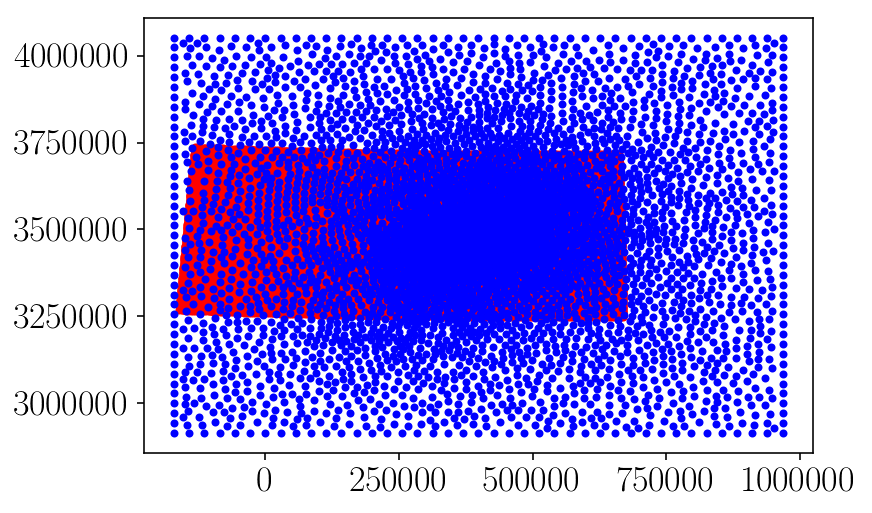

In [276]:
plt.plot(proj_dem[:,0], proj_dem[:,1], 'r.')
plt.plot(points[:,0], points[:,1], 'b.')
plt.show()

In [275]:
pt_elevations = scipy.interpolate.griddata(
    (proj_dem[:,0], proj_dem[:,1]), proj_dem[:,2],
    (points[:,0], points[:,1])
)
points[:,2] = get_pt_elevations(
    collect_dem.project(fault_m[0][:,0], fault_m[0][:,1], fault_m[0][:,2], proj, inverse = True),
    zoom
)
points[:,2] = pt_elevations
fault_m[0][upper_edge_idxs,2] = scipy.interpolate.griddata(
    (proj_dem[:,0], proj_dem[:,1]), proj_dem[:,2],
    (fault_m[0][upper_edge_idxs,0], fault_m[0][upper_edge_idxs,1])
)
from tectosaur.mesh.modify import concat
full_m = concat((points, cells['triangle']), fault_m)
#full_m[0][:,2] *= 20
np.save('mesh.npy', full_m)

A

A

A

A

A

A

A










In [ ]:
tris = scipy.spatial.Delaunay(np.vstack((LON, LAT)).T).simplices.copy()
proj_pts = collect_dem.project(LON, LAT, DEM, proj)
proj_m = (proj_pts, tris)

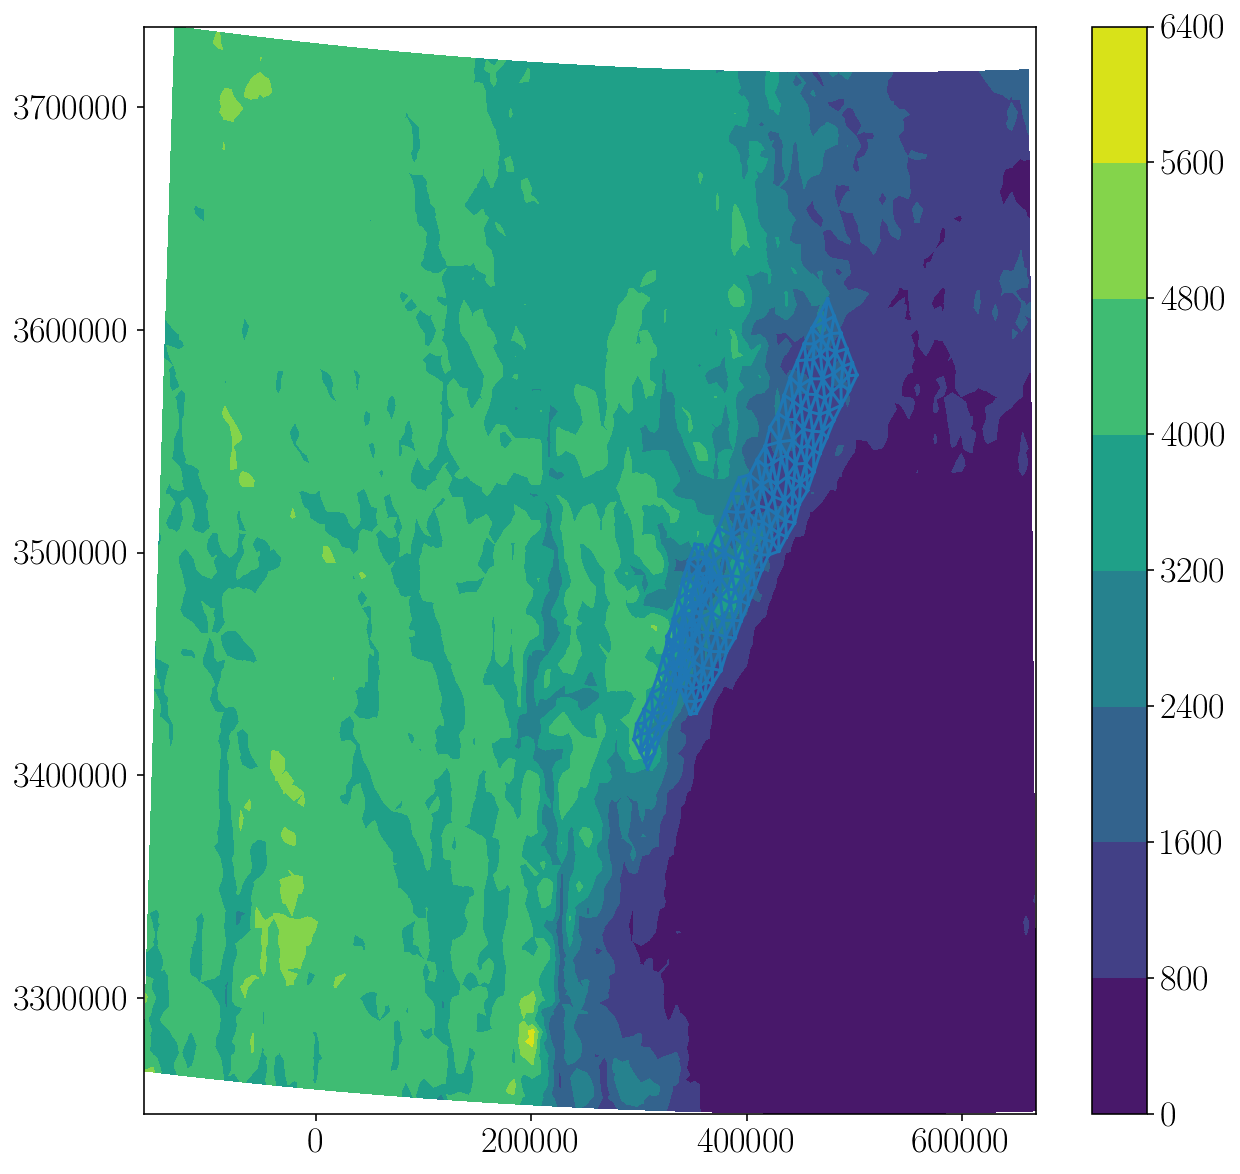

In [17]:
plt.figure(figsize = (10,10))
plt.tricontourf(proj_m[0][:,0], proj_m[0][:,1], proj_m[1], proj_m[0][:,2])
plt.triplot(fault_m[0][:,0], fault_m[0][:,1], fault_m[1])
plt.colorbar()
plt.show()